In [ ]:
import os
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e62646d0-8615-d826-4578-5091fab261ce)


In [ ]:
# Optional to save generator, checkpoint to your google drive
# Prevents data being erased if colab session disconnects
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Loading data:

In [ ]:
"""
The following is an import of PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import numpy as np
#import nibabel as ni
import os, shutil
import time
import random
import pandas as pd
import numpy as np
import os
import cv2
import numpy as np
import os
import cv2
from scipy import ndimage
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt

"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data processing

In [ ]:
def crop_around_centroid(array, dim1):
  i, j = ndimage.center_of_mass(array)
  i, j = int(i), int(j)
  w = int(dim1/2)
  imin = max(0,i-w)
  imax = min(array.shape[0],i+w+1)
  jmin = max(0,j-w)
  jmax = min(array.shape[1],j+w+1)
  crop =  array[imin:imax,jmin:jmax]
  return crop

def standard_resize2d(image, dim):
  resize_x,  resize_y = dim[0], dim[1]
  img_sm = cv2.resize(image, (resize_x, resize_y), interpolation=cv2.INTER_CUBIC)

  return img_sm


def split_train_test(dir, ratio_test=0.15):
    if not os.path.exists(os.path.join(dir, "train")): os.mkdir(os.path.join(dir, "train"))
    if not os.path.exists(os.path.join(dir, "test")): os.mkdir(os.path.join(dir, "test"))

    images_list = [i for i in os.listdir(dir) if i.endswith(".nii")]

    random.shuffle(images_list)
    threshold = int(len(images_list)*ratio_test)
    train_list = images_list[:-threshold]
    test_list = images_list[-threshold:]

    for i in train_list:
        shutil.move(os.path.join(dir, i), os.path.join(dir, "train", i))
    for i in test_list:
        shutil.move(os.path.join(dir, i), os.path.join(dir, "test", i))

def save_data_to_csv(dir, z):
    pd.DataFrame(z).to_csv(dir, header=None, index=False)

def load_data_images(path, batch_size):
    filenames = [i for i in os.listdir(path) if i.endswith(".npy")] #and i.startswith("norm_023_S_0030")
    random.shuffle(filenames, random.random)
    n = 0
    while n < len(filenames):
        batch_image = []
        for i in range(n, n + batch_size):
            #print(filenames[i])
            if i >= len(filenames):
                ##n = i
                break

            image = np.load(os.path.join(path, filenames[i]), allow_pickle=True)#[1, ...]
            image = np.where(image >= 1e-3, image, 0.0)
            image = crop_around_centroid(image, dim1=240)
            image = np.pad(image, ((1,0), (1,0)), "constant", constant_values=0)
            dim = (256,256)
            image = torch.Tensor(standard_resize2d(image, dim))
            #image = random_rotate_transforms(image)
            image = torch.reshape(image, (1,1, 256, 256))
            image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
            image = torch.where(image >= 0.1, image, 0.0)
            batch_image.append(image)

        n += batch_size
        batch_image = torch.cat(batch_image, axis=0)
        yield batch_image

## Util Functions

In [ ]:
import math
import pickle

import torch
from torch import distributed as dist
from torch.utils import data


LOCAL_PROCESS_GROUP = None


def is_primary():
    return get_rank() == 0


def get_rank():
    if not dist.is_available():
        return 0

    if not dist.is_initialized():
        return 0

    return dist.get_rank()


def get_local_rank():
    if not dist.is_available():
        return 0

    if not dist.is_initialized():
        return 0

    if LOCAL_PROCESS_GROUP is None:
        raise ValueError("tensorfn.distributed.LOCAL_PROCESS_GROUP is None")

    return dist.get_rank(group=LOCAL_PROCESS_GROUP)


def synchronize():
    if not dist.is_available():
        return

    if not dist.is_initialized():
        return

    world_size = dist.get_world_size()

    if world_size == 1:
        return

    dist.barrier()


def get_world_size():
    if not dist.is_available():
        return 1

    if not dist.is_initialized():
        return 1

    return dist.get_world_size()


def all_reduce(tensor, op=dist.ReduceOp.SUM):
    world_size = get_world_size()

    if world_size == 1:
        return tensor

    dist.all_reduce(tensor, op=op)

    return tensor


def all_gather(data):
    world_size = get_world_size()

    if world_size == 1:
        return [data]

    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    local_size = torch.IntTensor([tensor.numel()]).to("cuda")
    size_list = [torch.IntTensor([1]).to("cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.ByteTensor(size=(max_size,)).to("cuda"))

    if local_size != max_size:
        padding = torch.ByteTensor(size=(max_size - local_size,)).to("cuda")
        tensor = torch.cat((tensor, padding), 0)

    dist.all_gather(tensor_list, tensor)

    data_list = []

    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    world_size = get_world_size()

    if world_size < 2:
        return input_dict

    with torch.no_grad():
        keys = []
        values = []

        for k in sorted(input_dict.keys()):
            keys.append(k)
            values.append(input_dict[k])

        values = torch.stack(values, 0)
        dist.reduce(values, dst=0)

        if dist.get_rank() == 0 and average:
            values /= world_size

        reduced_dict = {k: v for k, v in zip(keys, values)}

    return reduced_dict


def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)

## GMM component

In [ ]:
"""
The following is an import of PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import numpy as np
#import nibabel as ni
import os, shutil
import time
import random
import pandas as pd
import numpy as np
import os
import cv2
import numpy as np
import os
import cv2
from scipy import ndimage
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt
import torch
import torch.nn.init as init
from torch import nn
from torch.nn import functional as F
#from networks.Layers import *


"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch
from torch import nn
from torch.nn import functional as F

# Flatten layer
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.size(0), -1)

# Reshape layer
class Reshape(nn.Module):
  def __init__(self, outer_shape):
    super(Reshape, self).__init__()
    self.outer_shape = outer_shape
  def forward(self, x):
    return x.view(x.size(0), *self.outer_shape)

# Sample from the Gumbel-Softmax distribution and optionally discretize.
class GumbelSoftmax(nn.Module):

  def __init__(self, f_dim, c_dim):
    super(GumbelSoftmax, self).__init__()
    self.logits = nn.Linear(f_dim, c_dim)
    self.f_dim = f_dim
    self.c_dim = c_dim

  def sample_gumbel(self, shape, is_cuda=False, eps=1e-20):
    U = torch.rand(shape)
    if is_cuda:
      U = U.to(device)
    return -torch.log(-torch.log(U + eps) + eps)

  def gumbel_softmax_sample(self, logits, temperature):
    y = logits + self.sample_gumbel(logits.size(), logits.is_cuda)
    return F.softmax(y / temperature, dim=-1)

  def gumbel_softmax(self, logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    #categorical_dim = 10
    y = self.gumbel_softmax_sample(logits, temperature)

    if not hard:
        return y

    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y
    return y_hard

  def forward(self, x, temperature=1.0, hard=False):
    logits = self.logits(x).view(-1, self.c_dim)
    prob = F.softmax(logits, dim=-1)
    y = self.gumbel_softmax(logits, temperature, hard)
    return logits, prob, y

# Sample from a Gaussian distribution
class Gaussian(nn.Module):
  def __init__(self, in_dim, z_dim):
    super(Gaussian, self).__init__()
    self.mu = nn.Linear(in_dim, z_dim)
    self.var = nn.Linear(in_dim, z_dim)

  def reparameterize(self, mu, var):
    std = torch.sqrt(var + 1e-10)
    noise = torch.randn_like(std)
    z = mu + noise * std
    return z

  def forward(self, x):
    mu = self.mu(x)
    var = F.softplus(self.var(x))
    z = self.reparameterize(mu, var)
    return mu, var, z

# Inference Network
class InferenceNet(nn.Module):
  def __init__(self, x_dim, z_dim, y_dim):
    super(InferenceNet, self).__init__()

    # q(y|x)
    self.inference_qyx = torch.nn.ModuleList([
        nn.Linear(x_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        GumbelSoftmax(512, y_dim)
    ])

    # q(z|y,x)
    self.inference_qzyx = torch.nn.ModuleList([
        nn.Linear(x_dim + y_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        Gaussian(512, z_dim)
    ])

  # q(y|x)
  def qyx(self, x, temperature, hard):
    num_layers = len(self.inference_qyx)
    for i, layer in enumerate(self.inference_qyx):
      if i == num_layers - 1:
        #last layer is gumbel softmax
        x = layer(x, temperature, hard)
      else:
        x = layer(x)
    return x

  # q(z|x,y)
  def qzxy(self, x, y):
    concat = torch.cat((x, y), dim=1)
    for layer in self.inference_qzyx:
      concat = layer(concat)
    return concat

  def forward(self, x, temperature=1.0, hard=0):
    #x = Flatten(x)

    # q(y|x)
    logits, prob, y = self.qyx(x, temperature, hard)

    # q(z|x,y)
    mu, var, z = self.qzxy(x, y)

    output = {'mean': mu, 'var': var, 'gaussian': z,
              'logits': logits, 'prob_cat': prob, 'categorical': y}
    return output


# Generative Network
class GenerativeNet(nn.Module):
  def __init__(self, x_dim, z_dim, y_dim):
    super(GenerativeNet, self).__init__()

    # p(z|y)
    self.y_mu = nn.Linear(y_dim, z_dim)
    self.y_var = nn.Linear(y_dim, z_dim)
    # p(x|z)
    self.generative_pxz = torch.nn.ModuleList([
        nn.Linear(z_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, x_dim),
        torch.nn.Sigmoid()
    ])

  # p(z|y)
  def pzy(self, y):
    y_mu = self.y_mu(y)
    y_var = F.softplus(self.y_var(y))
    return y_mu, y_var

  # p(x|z)
  def pxz(self, z):
    for layer in self.generative_pxz:
      z = layer(z)
    return z

  def forward(self, z, y):
    # p(z|y)
    y_mu, y_var = self.pzy(y)

    # p(x|z)
    x_rec = self.pxz(z)

    output = {'y_mean': y_mu, 'y_var': y_var, 'x_rec': x_rec}
    return output


# GMVAE Network
class GMVAENet(nn.Module):
  def __init__(self, x_dim, z_dim, y_dim):
    super(GMVAENet, self).__init__()
    self.inference = InferenceNet(x_dim, z_dim, y_dim)
    self.generative = GenerativeNet(x_dim, z_dim, y_dim)

    # weight initialization
    for m in self.modules():
      if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        torch.nn.init.xavier_normal_(m.weight)
        if m.bias.data is not None:
          init.constant_(m.bias, 0)

  def forward(self, x, temperature=1.0, hard=0):
    x = x.view(x.size(0), -1)
    out_inf = self.inference(x, temperature, hard)
    z, y = out_inf['gaussian'], out_inf['categorical']
    #out_gen = self.generative(z, y)

    # merge output
    #output = out_inf
    #for key, value in out_gen.items():
      #output[key] = value

    return z #output

## GM-VQVAE model

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

import distributed as dist_fn


# Copyright 2018 The Sonnet Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================


# Borrowed from https://github.com/deepmind/sonnet and ported it to PyTorch


class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(n_embed))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, input):
        flatten = input.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            embed_onehot_sum = embed_onehot.sum(0)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot

            all_reduce(embed_onehot_sum)
            all_reduce(embed_sum)

            self.cluster_size.data.mul_(self.decay).add_(
                embed_onehot_sum, alpha=1 - self.decay
            )
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, input):
        out = self.conv(input)
        out += input

        return out


class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()

        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(
                        channel // 2, out_channel, 4, stride=2, padding=1
                    ),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=1,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=64,
        n_embed=512,
        decay=0.99,
    ):
        super().__init__()
        n_embed=1024
        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        self.dec_t = Decoder(
            embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2
        )
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        self.upsample_t = nn.ConvTranspose2d(
            embed_dim, embed_dim, 4, stride=2, padding=1
        )
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )


    def forward(self, input, s):
        quant_t, quant_b, diff, _, _ = self.encode(input)
        #GMM  representation
        quant_t_scale, quant_b_scale = self.gmm_represent(quant_t, gaussian_size=quant_t.shape[-1], s=s), self.gmm_represent(quant_b, gaussian_size=quant_b.shape[-1], s=s)
        quant_t_scale, quant_b_scale =  quant_t_scale, quant_b_scale
        dec = self.decode(quant_t * torch.mean(quant_t_scale, dim=0).view(1, quant_t_scale.shape[1]), quant_b * torch.mean(quant_b_scale, dim=0).view(1, quant_b_scale.shape[1]))

        return dec, diff

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = torch.cat([upsample_t, quant_b], 1)
        dec = self.dec(quant)

        return dec

    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

    def gmm_represent(self, quant, gaussian_size, s):
      # GMM for quant_t
      input_size = quant.shape[1] * quant.shape[2] * quant.shape[3]
      num_classes = 1
      gmvae = GMVAENet(input_size, gaussian_size, num_classes).to(device)
      quant_out = quant.view(quant.shape[0], 1, quant.shape[1], -1)
      quant_out = gmvae(quant_out)

      return torch.sigmoid(quant_out * s)

# Evaluation

In [ ]:
import glob

def evaluate_step(path_data_list, path_model_list, model_name_list, threshold, label_list):
  mean_dsc_list = []
  mean_hd_list = []
  for i in range(len(path_model_list)):
    mean_dsc, mean_hd = evaluate_testset(path_data_list[i], path_model_list[i], threshold, label_list[i])
    mean_dsc_list.append(mean_dsc)
    mean_hd_list.append(mean_hd)

  metric_tbl  = pd.DataFrame(list(zip(model_name_list, mean_dsc_list, mean_hd_list)), columns =['Model', 'Surface DSC', "Hausdroff Distance"])
  return metric_tbl

def evaluate_testset(path_data, path_model, threshold, label):
    vae_model = torch.load(path_model, map_location=torch.device('cpu'))
    vae_model.to(device)
    dice_list = []
    hausdroff_list = []
    gt_list = glob.glob(path_data + "/*.npy")
    for gt in gt_list:
      if label == "all":
        gt = np.load(gt)
      else:
        gt = np.load(gt)[1, ...]
      gt = (gt - np.min(gt)) / (np.max(gt) - np.min(gt))
      gt = np.where(gt >= 0.1, 1.0, 0.0)
      # interfere phrase
      vae_model.eval()
      mask = pred_roi(gt, vae_model)
      # Mask
      #display_image3d(gt)
      mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
      mask = mask[1, ...]
      mask_t = np.where(mask >= threshold, 1.0, 0.0)
      #display_image3d(mask_t)
      sd = calculate_surface_dsc(mask_t.astype("bool"), gt.astype("bool"))
      print(sd)
      #mask_t = np.where(mask >= 3, 1.0, 0.0)
      hd = calculate_hausoff_dist(mask_t.astype("bool"), gt.astype("bool"))
      print(hd)
      dice_list.append(sd)
      hausdroff_list.append(hd)

    print(np.mean(dice_list))
    print(np.mean(hausdroff_list))
    return np.mean(dice_list), np.mean(hausdroff_list)

def pred_roi(gt, vae_model):
    gt = np.where(gt >= 0.2, gt, 0.0)
    pred = np.zeros(gt.shape)
    with torch.no_grad():
      for i in range(gt.shape[0]):
        if np.sum(gt[i, ...]) > 0:
          slice = gt.copy()[i, ...]
          crop, imin, imax, jmin, jmax = crop_around_centroid(slice, dim1=200)
          x = load_data_images(crop)
          y, latent_loss = vae_model(x.to(device))
          y = y.detach().cpu().numpy()
          dim = crop.shape
          y = standard_resize2d(y[0, 0, ...], dim)
          pred[i, imin:imax, jmin:jmax] = y

    return gt, pred

def crop_around_centroid(array, dim1):
  i, j = ndimage.center_of_mass(array)
  i, j = int(i), int(j)
  w = int(dim1/2)
  imin = max(0,i-w)
  imax = min(array.shape[0],i+w+1)
  jmin = max(0,j-w)
  jmax = min(array.shape[1],j+w+1)
  crop =  array[imin:imax,jmin:jmax]

  return crop, imin, imax, jmin, jmax

def load_data_images(image):
  image = np.pad(image, ((1,0), (1,0)), "constant", constant_values=0)
  dim = (256,256)
  image = torch.Tensor(standard_resize2d(image, dim))
  image = torch.reshape(image, (1,1, 256, 256))
  image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
  return image

## Metric define

In [ ]:
! git clone https://github.com/deepmind/surface-distance.git
! pip install surface-distance/

Cloning into 'surface-distance'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 50 (delta 9), reused 9 (delta 8), pack-reused 35
Receiving objects: 100% (50/50), 38.20 KiB | 869.00 KiB/s, done.
Resolving deltas: 100% (22/22), done.
Processing ./surface-distance
  Preparing metadata (setup.py) ... done
  Created wheel for Surface-Distance-Based-Measures: filename=Surface_Distance_Based_Measures-0.1-py3-none-any.whl size=14338 sha256=a359141568708f73380a30504bb077e1264d2ae3e8cf3c92a70d24600adaa5b3
  Stored in directory: /root/.cache/pip/wheels/00/ad/02/00434d46812b7b5d417bc11d1082d04edbc0e60f37511963b7
Successfully built Surface-Distance-Based-Measures


In [ ]:
import numpy as np
import os
import pandas as pd
import surface_distance


def calculate_surface_dsc(mask_pred, mask_gt):
    surface_distances = surface_distance.compute_surface_distances(
        mask_gt, mask_pred, spacing_mm=(3, 2, 1))
    surface_dsc = surface_distance.compute_surface_dice_at_tolerance(
            surface_distances, 3)

    return surface_dsc


def calculate_surface_dsc_2mm(mask_pred, mask_gt):
    surface_distances = surface_distance.compute_surface_distances(
        mask_gt, mask_pred, spacing_mm=(3, 2, 1))
    surface_dsc = surface_distance.compute_surface_dice_at_tolerance(
            surface_distances, 2)
    return surface_dsc

def calculate_surface_dscmm(mask_pred, mask_gt):
    surface_distances = surface_distance.compute_surface_distances(
        mask_gt, mask_pred, spacing_mm=(3, 2, 1))
    surface_dsc = surface_distance.compute_surface_dice_at_tolerance(
            surface_distances, 1)
    return surface_dsc

def calculate_hausoff_dist(mask_pred, mask_gt):
    surface_distances = surface_distance.compute_surface_distances(
        mask_gt, mask_pred, spacing_mm=(3, 2, 1))
    surface_dsc = surface_distance.compute_robust_hausdorff(
            surface_distances, 100)
    return surface_dsc

def calculate_volume(voxel_array, voxel_size):
    voxel =  np.sum(voxel_array)*np.array(voxel_size)
    return voxel[0]*voxel[1]*voxel[2]

## Exportation

Prediction

In [ ]:
def pred_roi(gt, vae_mode, s, t):
    gt = np.where(gt >= 0.2, gt, 0.0)
    pred = np.zeros(gt.shape)
    with torch.no_grad():
      for i in range(gt.shape[0]):
        if np.sum(gt[i, ...]) > 0:
          slice = gt.copy()[i, ...]
          crop, imin, imax, jmin, jmax = crop_around_centroid(slice, dim1=200)
          x = load_data_images(crop)
          y, latent_loss = vae_model(x.to(device), s)
          y = y.detach().cpu().numpy()
          dim = crop.shape
          y = standard_resize2d(y[0, 0, ...], dim)
          if y.sum() < 200*200:
            pred[i, imin:imax, jmin:jmax] = postprocess_mask(y.copy(), s)
          else:
            pred[i, imin:imax, jmin:jmax] = pred[i-1, imin:imax, jmin:jmax]

    result = pred.copy()
    return result

def crop_around_centroid(array, dim1):
  i, j = ndimage.center_of_mass(array)
  i, j = int(i), int(j)
  w = int(dim1/2)
  imin = max(0,i-w)
  imax = min(array.shape[0],i+w+1)
  jmin = max(0,j-w)
  jmax = min(array.shape[1],j+w+1)
  crop =  array[imin:imax,jmin:jmax]

  return crop, imin, imax, jmin, jmax

def load_data_images(image):
  image = np.pad(image, ((1,0), (1,0)), "constant", constant_values=0)
  dim = (256,256)
  image = torch.Tensor(standard_resize2d(image, dim))
  image = torch.reshape(image, (1,1, 256, 256))
  image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
  return image

def postprocess_mask(mask, s):
  mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
  mask = np.where(mask >= 0.3, 1.0, 0.0)
  if s <= 15:
    #mask_blur = gaussian_filter(mask, sigma=7)
  #elif s > 10 and s <= 15:
    mask_blur = gaussian_filter(mask, sigma=5)
  else:
    mask_blur = gaussian_filter(mask, sigma=3)

  return mask_blur

Visualize

In [ ]:
def plot_contour(ct, gt, mask, i, threshold):
  plt.imshow(ct[i, 150:450, 150:450], cmap="Greys_r", vmin=-250, vmax=250)

  # GT
  gt = np.where(gt > 0.1, 1.0, 0.0)

  plt.contour(gt[i, 150:450, 150:450], cmap="Greens")

  # Mask
  mask_t = np.where(mask > threshold, 1.0, 0.0)
  print(mask_t.shape)
  #print(dice(gt, mask_t))
  plt.contour(mask_t[i, 150:450, 150:450], cmap = "Reds")

  plt.show()

def display_image3d(x):
  z1,x1,y1 = x.nonzero()
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.scatter(x1, y1, z1, c=z1, cmap='viridis', alpha=0.7)
  plt.show()

## Export to DICOM

In [ ]:
import os
import pydicom
import numpy as np
from scipy import signal
import numpy as np
import nibabel as nib
import glob
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

In [ ]:
def display_image3d_multi(p, r, b):
  fig = plt.figure()
  ax = plt.axes(projection='3d')

  z1,x1,y1 = p.nonzero()
  ax.scatter(x1, y1, z1, c=z1, cmap='Greens', alpha=0.1)

  z2,x2,y2 = r.nonzero()
  ax.scatter(x2, y2, z2, c=z2, cmap='Greys', alpha=0.1)

  z3,x3,y3 = b.nonzero()
  ax.scatter(x3, y3, z3, c=z3, cmap='Reds', alpha=0.1)

  # rotate the axes and update
  ax.view_init(15, -60)
  plt.show()

def plot_contour(ct, gt, mask, i):
  plt.imshow(ct[i, 150:450, 150:450], cmap="Greys_r", vmin=-250, vmax=250)

  # GT
  gt_r = np.where(gt[0] > 0.1, 1.0, 0.0)
  gt_p = np.where(gt[1] > 0.1, 1.0, 0.0)
  gt_b = np.where(gt[2] > 0.1, 1.0, 0.0)
  plt.contour(gt_r[i, 150:450, 150:450], cmap="Greens")
  plt.contour(gt_p[i, 150:450, 150:450], cmap="Greens")
  plt.contour(gt_b[i, 150:450, 150:450], cmap="Greens")

  # Mask
  #mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
  mask_t_r = mask[0] #np.where(mask[0] >= threshold, 1.0, 0.0)
  mask_t_p = mask[1] #np.where(mask[1] >= threshold, 1.0, 0.0)
  mask_t_b = mask[2] #np.where(mask[2] >= threshold, 1.0, 0.0)
  #print(dice(gt, mask_t))
  plt.contour(mask_t_r[i, 150:400, 150:400], cmap = "Reds")
  plt.contour(mask_t_p[i, 150:400, 150:400], cmap = "Reds")
  plt.contour(mask_t_b[i, 150:400, 150:400], cmap = "Reds")

  plt.show()

In [ ]:
s_list = [5, 10, 15, 20]
t_list = [0.1, 0.3, 0.5, 0.7, 0.9]
for s in s_list:
    for t in t_list:
      print(f"s: {s}, t: {t}")

s: 5, t: 0.1
s: 5, t: 0.3
s: 5, t: 0.5
s: 5, t: 0.7
s: 5, t: 0.9
s: 10, t: 0.1
s: 10, t: 0.3
s: 10, t: 0.5
s: 10, t: 0.7
s: 10, t: 0.9
s: 15, t: 0.1
s: 15, t: 0.3
s: 15, t: 0.5
s: 15, t: 0.7
s: 15, t: 0.9
s: 20, t: 0.1
s: 20, t: 0.3
s: 20, t: 0.5
s: 20, t: 0.7
s: 20, t: 0.9


In [ ]:
def extract_data_list(subject_id, vae_model, s_list, t_list):
  dicom_dir = "/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/Test_data/Prostate-cases/" + str(subject_id)
  ct, slices, contours, labels, dummy_mask = dcm2npy(dicom_dir)
  #ct =nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/Processed_test_data/"  + str(subject_id) + "_0000.nii.gz").get_data().transpose((2, 1, 0))
  prostate = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Prostate/seg/" + str(subject_id) + ".nii.gz").get_data().transpose((2, 1, 0))
  rectum = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Rectum/seg/" + str(subject_id) + ".nii.gz").get_data().transpose((2, 1, 0))
  bladder = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Bladder/seg/" + str(subject_id) + ".nii.gz").get_data().transpose((2, 1, 0))

  prostate = np.flip(prostate, axis=(0, 1))
  rectum = np.flip(rectum,  axis=(0, 1))
  bladder = np.flip(bladder,  axis=(0, 1))

  prostate_list = [prostate]
  rectum_list = [rectum]
  bladder_list = [bladder]
  surface_dsc_list = []
  for s in s_list:
    for t in t_list:
      print(f"s: {s}, t: {t}")
      print(ct.shape)
      pred_mask_rectum, pred_mask_prostate, pred_mask_bladder, surface_dsc, hd = pred_contour(ct, prostate, rectum, bladder, vae_model, s, t)
      prostate_list.append(pred_mask_prostate)
      rectum_list.append(pred_mask_rectum)
      bladder_list.append(pred_mask_bladder)
      print(f"Surface DSC: {surface_dsc}")
      print(f"HD: {hd}")
  return slices, prostate_list, rectum_list, bladder_list

In [ ]:
def export_data(subject_id, vae_model, outpath):
  s_list = [5, 10, 15, 20]
  t_list = [0.1, 0.3, 0.5]
  n = len(s_list) * len(t_list)
  ct_slices, prostate_list, rectum_list, bladder_list = extract_data_list(subject_id, vae_model, s_list, t_list)

  prostate_name = ["original_prostate"]
  prostate_color = ["red"]
  for i in range(1, n+1):
    prostate_name.append("uncertainty_prostate_" + str(i))
    prostate_color.append("green")

  rectum_name = ["original_rectum"]
  rectum_color = ["red"]
  for i in range(1, n+1):
    rectum_name.append("uncertainty_rectum_" + str(i))
    rectum_color.append("green")

  bladder_name = ["original_bladder"]
  bladder_color = ["red"]
  for i in range(1, n+1):
    bladder_name.append("uncertainty_bladder_" + str(i))
    bladder_color.append("green")

  npy_outpath = os.path.join(outpath + "/npy/" + str(subject_id))
  if not os.path.exists(npy_outpath):
   # Create a new directory because it does not exist
   os.makedirs(npy_outpath)
   print("The new directory is created!")

  np.save(os.path.join(npy_outpath, str(subject_id) + '_prostate.npy'), np.stack(prostate_list))
  np.save(os.path.join(npy_outpath, str(subject_id) + '_rectum.npy'), np.stack(rectum_list))
  np.save(os.path.join(npy_outpath, str(subject_id) + '_bladder.npy'), np.stack(bladder_list))
  RTStruct(prostate_list + rectum_list + bladder_list, prostate_name + rectum_name + bladder_name, color=prostate_color + rectum_color + bladder_color, DICOMImageStruct = ct_slices, fname=os.path.join(outpath + "/dicom", str(subject_id) + '.dcm'))


In [ ]:
def pred_contour(ct, prostate, rectum, bladder, vae_model, s, t):
  # Slicing
  vae_model.eval()
  '''
  ct = ct[40:44, ...]

  rectum = rectum[40:44, ...]
  prostate = prostate[40:44, ...]
  bladder = bladder[40:44, ...]
  '''

  # Predict & postprocess
  pred_rectum = pred_roi(rectum, vae_model, s, t)
  pred_rectum = (pred_rectum >  t).astype("bool")
  pred_prostate = pred_roi(prostate, vae_model, s, t)
  pred_prostate = (pred_prostate >  t).astype("bool")
  pred_bladder = pred_roi(bladder, vae_model, s, t)
  pred_bladder = (pred_bladder >  t).astype("bool")

  #display_image3d_multi(pred_prostate, pred_rectum, pred_bladder)
  gt = np.stack([rectum, bladder, prostate])
  mask =  np.stack([pred_rectum, pred_bladder, pred_prostate])
  surface_dsc = calculate_surface_dsc((pred_prostate + pred_rectum + pred_bladder).astype("bool"), (prostate + rectum + bladder).astype("bool"))
  hd = calculate_hausoff_dist((pred_prostate + pred_rectum + pred_bladder).astype("bool"), (prostate + rectum + bladder).astype("bool"))
  i = 80
  plot_contour(ct, gt, mask, i)
  return pred_rectum, pred_prostate, pred_bladder, surface_dsc, hd

In [ ]:
import numpy as np
import nibabel as nib


path_model = "/content/drive/MyDrive/Dissertation-project/checkpoint/2d_vae/vqvae/vqvae_n1024/joint/model_vae_epoch_100.pt"
vae_model = torch.load(path_model, map_location=torch.device('cpu'))
vae_model.to(device)

outpath = "/content/drive/MyDrive/Dissertation-project/Exportation/Exported_masks/"


for subject_id in range(18, 30+1):
  try:
    start = time.time()
    export_data(subject_id, vae_model, outpath)
    end = time.time()
    print("Running time:" + str(end-start))
  except Exception as e:
    print(e)
    pass

Output hidden; open in https://colab.research.google.com to view.

# Rename exportation:

In [ ]:
def pred_contour(ct, prostate, rectum, bladder, pred_prostate, pred_rectum, pred_bladder):
  # Slicing
  vae_model.eval()

  prostate = np.flip(prostate, axis=(0, 1))
  rectum = np.flip(rectum,  axis=(0, 1))
  bladder = np.flip(bladder,  axis=(0, 1))

  # Predict & postprocess
  pred_rectum = pred_rectum
  pred_rectum = (pred_rectum >  0).astype("bool")
  pred_prostate = pred_prostate
  pred_prostate = (pred_prostate >  0).astype("bool")
  pred_bladder = pred_bladder
  pred_bladder = (pred_bladder >  0).astype("bool")

  #display_image3d_multi(pred_prostate, pred_rectum, pred_bladder)
  gt = np.stack([rectum, bladder, prostate])
  mask =  np.stack([pred_rectum, pred_bladder, pred_prostate])
  surface_dsc = calculate_surface_dsc((pred_prostate + pred_rectum + pred_bladder).astype("bool"), (prostate + rectum + bladder).astype("bool"))
  hd = calculate_hausoff_dist((pred_prostate + pred_rectum + pred_bladder).astype("bool"), (prostate + rectum + bladder).astype("bool"))
  i = 80
  #plot_contour(ct, gt, mask, i)
  return pred_rectum, pred_prostate, pred_bladder, surface_dsc, hd

In [ ]:
def filter_bad_pred(pred):
  for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
      s = pred[i, j, ...].copy()
      if s.sum() > 0:
        crop, imin, imax, jmin, jmax = crop_around_centroid(s, dim1=200)
        check_slice = s[imin:imax, jmin:jmax]
        if check_slice.sum() >= 200*200:
          pred[i, j, imin:imax, jmin:jmax] = pred[i, j-1, imin:imax, jmin:jmax]
  return pred

In [ ]:
def extract_data_list(subject_id, vae_model, s_list, t_list):
  dicom_dir = "/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/Test_data/Prostate-cases/" + str(subject_id)
  ct, slices, contours, labels, dummy_mask = dcm2npy(dicom_dir)
  #ct =nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/Processed_test_data/"  + str(subject_id) + "_0000.nii.gz").get_data().transpose((2, 1, 0))
  prostate = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Prostate/seg/" + str(subject_id) + ".nii.gz").get_data().transpose((2, 1, 0))
  rectum = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Rectum/seg/" + str(subject_id) + ".nii.gz").get_data().transpose((2, 1, 0))
  bladder = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Bladder/seg/" + str(subject_id) + ".nii.gz").get_data().transpose((2, 1, 0))

  prostate = np.flip(prostate, axis=(0, 1))
  rectum = np.flip(rectum,  axis=(0, 1))
  bladder = np.flip(bladder,  axis=(0, 1))

  pred_prostate = np.load(os.path.join("/content/drive/MyDrive/Dissertation-project/Exportation/Exported_masks/npy/" + str(subject_id), str(subject_id) + "_prostate.npy"))
  pred_rectum = np.load(os.path.join("/content/drive/MyDrive/Dissertation-project/Exportation/Exported_masks/npy/" + str(subject_id), str(subject_id) + "_rectum.npy"))
  pred_bladder = np.load(os.path.join("/content/drive/MyDrive/Dissertation-project/Exportation/Exported_masks/npy/" + str(subject_id), str(subject_id) + "_bladder.npy"))

  pred_prostate = filter_bad_pred(pred_prostate)
  pred_rectum = filter_bad_pred(pred_rectum)
  pred_bladder = filter_bad_pred(pred_bladder)

  prostate_list = [prostate]
  rectum_list = [rectum]
  bladder_list = [bladder]
  surface_dsc_list = []
  s_list = ["5", "10", "15", "20"]
  t_list = ["0.1", "0.3", "0.5"]

  st_list = []
  for s in s_list:
    for t in t_list:
      st_list.append("s: " + str(s) + ", t: " + str(t))
  surface_dsc_list = []
  hd_list = []
  for i in range(pred_prostate.shape[0]):
      print(st_list[i])
      print(ct.shape)
      pred_mask_rectum, pred_mask_prostate, pred_mask_bladder, surface_dsc, hd = pred_contour(ct, prostate, rectum, bladder, pred_prostate[i, ...], pred_rectum[i, ...], pred_bladder[i, ...])
      surface_dsc_list.append(surface_dsc)
      hd_list.append(hd)
      prostate_list.append(pred_mask_prostate)
      rectum_list.append(pred_mask_rectum)
      bladder_list.append(pred_mask_bladder)
      print(f"Surface DSC: {surface_dsc}")
      print(f"HD: {hd}")
  return slices, prostate_list, rectum_list, bladder_list, surface_dsc_list, hd_list

In [ ]:
def export_data(subject_id, vae_model, outpath):
  s_list = [5, 10, 15, 20]
  t_list = [0.1, 0.3, 0.5]
  n = len(s_list) * len(t_list)
  ct_slices, prostate_list, rectum_list, bladder_list, surface_dsc_list, hd_list = extract_data_list(subject_id, vae_model, s_list, t_list)

  prostate_name = ["original_prostate"]
  prostate_color = ["red"]
  for i in range(1, n+1):
    prostate_name.append("uncertainty_prostate_" + str(i))
    prostate_color.append("green")

  rectum_name = ["original_rectum"]
  rectum_color = ["red"]
  for i in range(1, n+1):
    rectum_name.append("uncertainty_rectum_" + str(i))
    rectum_color.append("green")

  bladder_name = ["original_bladder"]
  bladder_color = ["red"]
  for i in range(1, n+1):
    bladder_name.append("uncertainty_bladder_" + str(i))
    bladder_color.append("green")

  RTStruct(prostate_list + rectum_list + bladder_list, prostate_name + rectum_name + bladder_name, color=prostate_color + rectum_color + bladder_color, DICOMImageStruct = ct_slices, fname=os.path.join(outpath + "/dicom", str(subject_id) + '.dcm'))

  return surface_dsc_list, hd_list

In [ ]:
import numpy as np
import nibabel as nib


path_model = "/content/drive/MyDrive/Dissertation-project/checkpoint/2d_vae/vqvae/vqvae_n1024/joint/model_vae_epoch_100.pt"
vae_model = torch.load(path_model, map_location=torch.device('cpu'))
vae_model.to(device)

outpath = "/content/drive/MyDrive/Dissertation-project/Exportation/Exported_masks/"

subject_surface_dsc = {}
subject_hd = {}
for subject_id in range(11, 30+1):
  try:
    print("subject_id")
    print(subject_id)
    start = time.time()
    surface_dsc_list, hd_list = export_data(subject_id, vae_model, outpath)
    subject_surface_dsc[str(subject_id)] = surface_dsc_list
    subject_hd[str(subject_id)] = hd_list
    print(subject_surface_dsc)
    print(subject_hd)
    end = time.time()
    print("Running time:" + str(end-start))

  except Exception as e:
    print(e)
    pass


subject_id
11
   Missing contours for structure: CTV
   Missing contours for structure: sigmoid
   Missing contours for structure: ROI_1
   Missing contours for structure: sigmoid Avoid JK


<ipython-input-15-ca50af20426d>:243: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_map = np.zeros([shape[0], shape[1], shape[2], len(contours)], dtype=np.bool)
<ipython-input-15-ca50af20426d>:335: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_map = label_map.astype(np.bool)
<ipython-input-74-c00afb1fd3a3>:5: DeprecationWarning: get_data

s: 5, t: 0.1
(187, 512, 512)
Surface DSC: 0.0
HD: 174.41330224498358
s: 5, t: 0.3
(187, 512, 512)
Surface DSC: 0.0
HD: 174.18381095842403
s: 5, t: 0.5
(187, 512, 512)
Surface DSC: 0.0
HD: 258.24213443975407
s: 10, t: 0.1
(187, 512, 512)
Surface DSC: 0.0
HD: 174.12926233117742
s: 10, t: 0.3
(187, 512, 512)
Surface DSC: 0.0
HD: 259.3260495977988
s: 10, t: 0.5
(187, 512, 512)
Surface DSC: 0.0
HD: 177.10448893238137
s: 15, t: 0.1
(187, 512, 512)
Surface DSC: 0.0
HD: 174.58808664969095
s: 15, t: 0.3
(187, 512, 512)
Surface DSC: 0.0
HD: 174.04597093871493
s: 15, t: 0.5
(187, 512, 512)
Surface DSC: 0.0
HD: 174.28998823799375
s: 20, t: 0.1
(187, 512, 512)
Surface DSC: 0.0
HD: 174.58808664969095
s: 20, t: 0.3
(187, 512, 512)
Surface DSC: 0.0
HD: 174.24408167854654
s: 20, t: 0.5
(187, 512, 512)
Surface DSC: 0.0
HD: 230.0


<ipython-input-15-ca50af20426d>:807: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = morphology.remove_small_objects(pred, np.int(unique_volume[-num_volume-1] - 1))
/usr/local/lib/python3.10/dist-packages/pydicom/valuerep.py:443: UserWarning: The value length (23) exceeds the maximum length of 16 allowed for VR SH.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/pydicom/valuerep.py:443: UserWarning: The value length (20) exceeds the maximum length of 16 allowed for VR SH.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packa

{'11': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
{'11': [174.41330224498358, 174.18381095842403, 258.24213443975407, 174.12926233117742, 259.3260495977988, 177.10448893238137, 174.58808664969095, 174.04597093871493, 174.28998823799375, 174.58808664969095, 174.24408167854654, 230.0]}
Running time:161.6404128074646
subject_id
12
s: 5, t: 0.1
(214, 512, 512)
Surface DSC: 0.0
HD: 273.045783706689
s: 5, t: 0.3
(214, 512, 512)
Surface DSC: 0.0
HD: 273.0
s: 5, t: 0.5
(214, 512, 512)
Surface DSC: 0.0
HD: 273.0
s: 10, t: 0.1
(214, 512, 512)
Surface DSC: 0.0
HD: 341.7045507452308
s: 10, t: 0.3
(214, 512, 512)
Surface DSC: 0.0
HD: 273.0
s: 10, t: 0.5
(214, 512, 512)
Surface DSC: 0.0
HD: 289.12454063949673
s: 15, t: 0.1
(214, 512, 512)
Surface DSC: 0.0
HD: 345.9103930210828
s: 15, t: 0.3
(214, 512, 512)
Surface DSC: 0.0
HD: 273.00732590903124
s: 15, t: 0.5
(214, 512, 512)
Surface DSC: 0.0
HD: 270.0
s: 20, t: 0.1
(214, 512, 512)
Surface DSC: 0.0
HD: 273.00732590903124
s: 20, t: 

In [ ]:
prostate = np.load("/content/drive/MyDrive/Dissertation-project/Exportation/Exported_masks/npy/11/11_prostate.npy")
prostate.shape

(12, 187, 512, 512)

In [ ]:
for s in prostate[11, ...]:
  if s.sum() > 0:
    crop, imin, imax, jmin, jmax = crop_around_centroid(s, dim1=200)
    check_slice = s[imin:imax, jmin:jmax]

    if check_slice.sum() >= 200*200:
      print("all ones")

all ones


In [ ]:
200 * 200

40000

In [ ]:
np.ones(check_slice.shape).sum()

40401.0

In [ ]:
import numpy as np
a = np.array(([0,0,0,0],
              [0,1,1,0],
              [0,1,1,0],
              [0,1,1,0]))
from scipy import ndimage
ndimage.center_of_mass(a)
a.dtype

dtype('int64')

In [ ]:
"/content/drive/MyDrive/Dissertation-project/Exportation/Exported_masks/npy/11/11_prostate.npy" == "/content/drive/MyDrive/Dissertation-project/Exportation/Exported_masks/npy/11/11_prostate.npy"

True

## Export

In [ ]:
s_list = ["5", "10", "15", "20"]
t_list = ["0.1", "0.3", "0.5"]

st_list = []
for s in s_list:
  for t in t_list:
    st_list.append("s: " + str(s) + ", t: " + str(t))
st_list

['s: 5, t: 0.1',
 's: 5, t: 0.3',
 's: 5, t: 0.5',
 's: 10, t: 0.1',
 's: 10, t: 0.3',
 's: 10, t: 0.5',
 's: 15, t: 0.1',
 's: 15, t: 0.3',
 's: 15, t: 0.5',
 's: 20, t: 0.1',
 's: 20, t: 0.3',
 's: 20, t: 0.5']

In [ ]:
metric_table

,s,t,surface DSC,HD
0,5,0.1,0,0
1,5,0.3,0,0
2,5,0.5,0,0
3,10,0.1,0,0
4,10,0.3,0,0
5,10,0.5,0,0
6,15,0.1,0,0
7,15,0.3,0,0
8,15,0.5,0,0
9,20,0.1,0,0


In [ ]:
for s in s_list:
  for t in t_list:
    metric_table.loc[(metric_table["s"] == s) & (metric_table["t"] == t)]["surface DSC"] = 2

<ipython-input-223-2050369c3d64>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_table.loc[(metric_table["s"] == s) & (metric_table["t"] == t)]["surface DSC"] = 2


In [ ]:
metric_table

,s,t,surface DSC,HD
0,5,0.1,0,0
1,5,0.3,0,0
2,5,0.5,0,0
3,10,0.1,0,0
4,10,0.3,0,0
5,10,0.5,0,0
6,15,0.1,0,0
7,15,0.3,0,0
8,15,0.5,0,0
9,20,0.1,0,0


In [ ]:
import time

path_model = "/content/drive/MyDrive/Dissertation-project/checkpoint/2d_vae/vqvae/vqvae_n1024/joint/model_vae_epoch_100.pt"
vae_model = torch.load(path_model, map_location=torch.device('cpu'))
vae_model.to(device)

ct_path = "/content/drive/MyDrive/Dissertation-project/Data/3D_CT_Dataset/1kDataset/dataset6_CLINIC_0002_data_0000_0000.nii.gz"
subject_id = "dataset6_CLINIC_0002_data_0000"

outpath = "/content/drive/MyDrive/Dissertation-project/Exportation/Exported_masks/dicom/"

start = time.time()
export_data(ct_path, vae_model, subject_id, s_list, t_list, outpath)
end = time.time()
print("Running time:" + str(end-start))

TypeError: ignored

In [ ]:
## Exportation
#prostate_list = [gt_p_11, sub1_results1[0], sub1_results1[1], sub1_results1[2], sub1_results1[3], sub1_results1[4]]
prostate_name = ["truth_prostate", "auto_prostate_1", "auto_prostate_2", "auto_prostate_3", "auto_prostate_4", "auto_prostate_5"]
prostate_color = ["red", "green", "purple", "yellow", "blue", "orange"]
rectum_list = [gt_r_11, sub1_results2[0], sub1_results2[1], sub1_results2[2], sub1_results2[3], sub1_results2[4]]
rectum_name = ["truth_rectum", "auto_rectum_1", "auto_rectum_2", "auto_rectum_3", "auto_rectum_4", "auto_rectum_5"]
rectum_color = ["red", "purple", "yellow", "blue", "orange", "green"]
bladder_list = [gt_b_11, sub1_results3[0], sub1_results3[1], sub1_results3[2], sub1_results3[3], sub1_results3[4]]
bladder_name = ["truth_bladder", "auto_bladder_1", "auto_bladder_2", "auto_bladder_3", "auto_bladder_4", "auto_bladder_5"]
bladder_color = ["red", "green", "purple", "yellow", "blue", "orange"]

#destination_path = "../"
destination_path = "Output"
RTStruct(prostate_list + rectum_list + bladder_list, prostate_name + rectum_name + bladder_name, color=prostate_color + rectum_color + bladder_color, DICOMImageStruct = slices_11, fname=os.path.join(destination_path, 'subject_11_contours_7_3.dcm'))
end = time.time()
print("Running time:" + str(end-start))
pool.close()

## Dicom Utils

In [ ]:
!pip install SimpleITK pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 93.0 MB/s eta 0:00:00


In [ ]:
# -*- coding: utf-8 -*-
"""
Code written by Carlos E. Cardenas 9.21.2018
email: cecardenas@mdanderson.org

Do not distribute without permission
"""

import os, glob, pickle

import SimpleITK as sitk
import pydicom as dicom
from pydicom.uid import generate_uid
from pydicom.dataset import Dataset, FileDataset
from pydicom.sequence import Sequence
from skimage import morphology
import numpy as np

import matplotlib.pyplot as plt
from skimage.draw import polygon
import skimage.morphology as skmo
import skimage.measure as skme
import skimage.transform as sktm
import cv2

import logging, time, datetime

# change
def read_images_labels(path, im_tag='CT', rs_tag='RTSTRUCT', ds_tag='RTDOSE', plan_tag='RTPLAN', rois=None, verbose=False):
    """Reads the images and labels from a folder containing both dicom files

    Args:
        path:           Path containing all DICOM files
        im_tag:         DICOM image file name tag (first letters for this file type)
        rs_tag:         DICOM RT Structure file name tag (first letters for this file type)
        ds_tag:         DICOM RT Dose file name tag (first letters for this file type)
        plan_tag:       DICOM RT Plan file name tag (first letters for this file type)
        rois:           Array of string containing defined rois to extract (i.e. ['Mandible', 'Cord']). Choosing 'None'
                        imports all rois in the DICOM RT Structure files located in 'path'.
    Returns:
        image:          Numpy array (slice, row, column) containing the appended slices (from each DICOM image file)
                        to create a 3D array.
        dicom_info:     Dictionary containing the DICOM information for each slice corresponding to 'image'
        contours:       List of dictionaries containing roi points and information for each roi in the list.
        dose:           CURRENTLY EMPTY
        plan_info:      CURRENTLY EMPTY

    To do:
        Add component to read RTDOSE files and convert them to numpy arrays.
        Add component to read RTPLAN files.

    """

    image = []
    dicom_info = []
    contours = []
    dose = []
    plan_info = []

    if im_tag is None:
        im_tag = ''
    if rs_tag is None:
        rs_tag = ''
    if ds_tag is None:
        ds_tag = ''
    if plan_tag is None:
        plan_tag = ''

    if any([im_tag == rs_tag, im_tag == plan_tag, im_tag == ds_tag, rs_tag == plan_tag, rs_tag == ds_tag,
            ds_tag == plan_tag]):

        start = time.time()
        dcm_paths = []
        for subdir, dirs, files in os.walk(path):
            dcms = glob.glob(os.path.join(subdir, im_tag + '*.dcm'))
            if len(dcms) > 0:
                dcm_paths.extend(dcms)
            if not rs_tag == None:
                dcms = glob.glob(os.path.join(subdir, rs_tag + '*.dcm'))
                if len(dcms) > 0:
                    dcm_paths.extend(dcms)
            if not ds_tag == None:
                dcms = glob.glob(os.path.join(subdir, ds_tag + '*.dcm'))
                if len(dcms) > 0:
                    dcm_paths.extend(dcms)
            if not plan_tag == None:
                dcms = glob.glob(os.path.join(subdir, plan_tag + '*.dcm'))
                if len(dcms) > 0:
                    dcm_paths.extend(dcms)

        dcm_paths = list(set(dcm_paths))
        # print('elapsed time getting file paths: ' + str(time.time()-start))
        start = time.time()
        for dcm_path in dcm_paths:
            dcm_info = dicom.read_file(dcm_path)
            mod = dcm_info.Modality
            if mod == 'CT' or mod == 'MR' or mod == 'PT':
                try:
                    hi = float(dcm_info.ImagePositionPatient[2])
                except:
                    continue
                dicom_info.append(dcm_info)
            elif mod == "RTSTRUCT":
                if not rs_tag == None:
                    rs_start = time.time()
                    tmp = read_contours(dicom_dataset=dcm_info, rois=rois)
                    # print('elapsed time reading contours: ' + str(time.time()-rs_start))
                    contours.extend(tmp)
            elif mod == "RTPLAN":
                if not plan_tag == None:
                    plan_info.append(dicom.read_file(dcm_path))
            elif mod == "RTDOSE":
                if not ds_tag == None:
                    dose.append(dicom.read_file(dcm_path))

        # print('elapsed time loading dicoms: ' + str(time.time()-start))
        dicom_info.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        image = np.stack([s.pixel_array for s in dicom_info], axis=0).astype(np.float32)
        image = image + dicom_info[0].RescaleIntercept

    else:
        for subdir, dirs, files in os.walk(path):
            dcms = glob.glob(os.path.join(subdir, im_tag+'*.dcm'))
            if len(dcms) > 1:
                dicom_info = [dicom.read_file(dcm) for dcm in dcms]
                dicom_info.sort(key=lambda x: float(x.ImagePositionPatient[2]))
                image = np.stack([s.pixel_array for s in dicom_info], axis=0).astype(np.float32)
                if dicom_info[0].Modality == 'CT':
                    image = image + dicom_info[0].RescaleIntercept
            else:
                if verbose:
                    print('  Missing image files with tag: ' + im_tag)

            if not rs_tag == None:
                dcms = glob.glob(os.path.join(subdir, rs_tag+'*.dcm'))
                if len(dcms) >= 1:
                    for dcm in dcms:
                        tmp = read_contours(dcm, rois=rois)
                        contours.extend(tmp)
                else:
                    if verbose:
                        print('  Missing RS file with tag: ' + rs_tag)
            if not ds_tag == None:
                dcms = glob.glob(os.path.join(subdir, ds_tag + '*.dcm'))
                if len(dcms) >= 1:
                    for dcm in dcms:
                        dose.append(dicom.read_file(dcm))

            if not plan_tag == None:
                dcms = glob.glob(os.path.join(subdir, plan_tag + '*.dcm'))
                if len(dcms) >= 1:
                    for dcm in dcms:
                        plan_info.append(dicom.read_file(dcm))

    return image, dicom_info, contours, dose, plan_info


def read_contours(dicom_path=None, dicom_dataset=None, rois=None):
    """ Reads the DICOM RT Structure file and outputs a list of dictionaries with roi points and relevant information
        for each roi.

    Args:
        dicom_path:     Path containing the DICOM RT Structure file
        dicom_dataset:  Dicom Dataset from pydicom
        rois:           Array of string containing defined rois to extract (i.e. ['Mandible', 'Cord']).
                        Choosing 'None' imports all rois in the DICOM RT Structure files located in 'dicom_path'.
    Returns:
        contours:       List of dictionaries containing roi points and information for each roi in the list.

    """
    contours = []
    if dicom_dataset is None and dicom_path is not None:
        structure = dicom.read_file(dicom_path)
    elif dicom_dataset is not None and dicom_path is None:
        structure = dicom_dataset
    else:
        print('Either a dicom file path or a pydicom dataset are required to read contours')
        return contours

    for i in range(len(structure.ROIContourSequence)):
        if rois is None:
            contour = {}
            try:
                contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
            except AttributeError:
                contour['color'] = dicom.multival.MultiValue(dicom.valuerep.IS, ['0', '0', '0'])
            contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber
            contour['name'] = structure.StructureSetROISequence[i].ROIName
            assert contour['number'] == structure.StructureSetROISequence[i].ROINumber
            try:
                contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
            except AttributeError:
                contour['contours'] = []
                print('   Missing contours for structure: ' + contour['name'])
            contours.append(contour)
        else:
            for roi in rois:
                if roi == structure.StructureSetROISequence[i].ROIName:
                    contour = {}
                    try:
                        contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
                    except AttributeError:
                        contour['color'] = dicom.multival.MultiValue(dicom.valuerep.IS, ['0', '0', '0'])
                    contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber
                    contour['name'] = structure.StructureSetROISequence[i].ROIName
                    assert contour['number'] == structure.StructureSetROISequence[i].ROINumber
                    try:
                        contour['contours'] = []
                        contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
                    except AttributeError:
                        print('   Missing contours for structure: ' + contour['name'])
                    contours.append(contour)
                    break
    return contours


def get_labels(contours, shape, dicom_info, rois=None):
    """ Uses the outputs from the function "read_images_labels" to convert the contours to boolean numpy arrays.

    Args:
        contours:       List of dictionaries containing roi points and information for each roi in the list.
                        This is one of the outputs from the function "read_images_labels"
        shape:          Tuple. Shape of the 3D image for which the contours were delineated on.
        dicom_info:     Dictionary containing the DICOM information for each slice corresponding to the 3D image
        rois:           Array of string containing defined rois to extract (i.e. ['Mandible', 'Cord']).
                        Choosing 'None' imports all rois found in 'contours'.

    Returns:
        label_map:      Boolean numpy array of shape equal to 'shape' for the corresponding rois found in 'contours'.

    """
    if not contours == []:

        z = [np.around(s.ImagePositionPatient[2], 1) for s in dicom_info]
        pos_r = dicom_info[0].ImagePositionPatient[1] * dicom_info[0].ImageOrientationPatient[0]
        spacing_r = dicom_info[0].PixelSpacing[1]
        pos_c = dicom_info[0].ImagePositionPatient[0] * dicom_info[0].ImageOrientationPatient[0]
        spacing_c = dicom_info[0].PixelSpacing[0]



        if rois is None:
            label_map = np.zeros([shape[0], shape[1], shape[2], len(contours)], dtype=np.bool)
            num = 1
            ct = 0
            for con in contours:
                for c in con['contours']:
                    contoured_points = np.array(c).reshape((-1, 3))
                    if contoured_points.shape[0] > 1:
                        assert np.amax(np.abs(np.diff(contoured_points[:, 2]))) == 0
                        try:
                            z_index = z.index(np.around(contoured_points[0, 2], 1))
                        except ValueError:
                            print("   Missing CT slice")
                            break
                        r = (contoured_points[:, 1] - pos_r) / spacing_r
                        c = (contoured_points[:, 0] - pos_c) / spacing_c
                        rr, cc = polygon(r, c)
                        if any(rr > 511) or any(rr < 0) or any(cc < 0) or any(cc > 511):
                            rr[rr > 511] = label_map.shape[1]-1
                            rr[rr < 0] = 0
                            cc[cc > 511] = label_map.shape[2]-1
                            cc[cc < 0] = 0
                        label_map[z_index, rr, cc, ct] = True
                        if dicom_info[0].ImageOrientationPatient[0] == -1:
                            label_map[z_index, :, :, ct] = np.flipud(label_map[z_index, :, :, ct])
                ct += 1
        else:
            if type(rois) == list:
                if len(rois) <= 1:
                    label_map = np.zeros([shape[0], shape[1], shape[2]], dtype=np.bool)
                else:
                    label_map = np.zeros([shape[0], shape[1], shape[2], len(rois)], dtype=np.bool)
            elif type(rois) == str:
                label_map = np.zeros([shape[0], shape[1], shape[2]], dtype=np.bool)

            # finding match between contour_names and roi_names
            names_in_contours = []
            for c in contours:
                names_in_contours.append(c['name'])

            idx = []
            if type(rois) == list:
                for roi in rois:
                    ct = 0
                    found = False
                    for name in names_in_contours:
                        if name == roi:
                            idx.append(ct)
                            found = True
                            break
                        else:
                            ct += 1
                    if found == False:
                        idx.append(-1)
            elif type(rois) == str:
                idx = []
                found = False
                for ct, name in enumerate(names_in_contours):
                    if name == rois:
                        idx.append(ct)
                        found = True
                        break
                if found == False:
                    idx.append(-1)

            for i, index in enumerate(idx):
                if index >= 0:
                    num = 1
                    con = contours[index]
                    for c in con['contours']:
                        nodes = np.array(c).reshape((-1, 3))
                        if nodes.shape[0] > 1:
                            assert np.amax(np.abs(np.diff(nodes[:, 2]))) < 0.0001
                            try:
                                z_index = z.index(np.around(nodes[0, 2], 1))
                            except ValueError:
                                print("   Missing CT slice")
                                break
                            r = (nodes[:, 1] - pos_r) / spacing_r
                            c = (nodes[:, 0] - pos_c) / spacing_c
                            rr, cc = polygon(r, c)
                            if any(rr > 511) or any(rr < 0) or any(cc < 0) or any(cc > 511):
                                rr[rr > 511] = label_map.shape[1] - 1
                                rr[rr < 0] = 0
                                cc[cc > 511] = label_map.shape[2] - 1
                                cc[cc < 0] = 0
                            if type(rois) == list:
                                if len(rois) <= 1:
                                    label_map[z_index, rr, cc] = num
                                else:
                                    label_map[z_index, rr, cc, i] = num
                            elif type(rois) == str:
                                label_map[z_index, rr, cc] = num
        label_map = label_map.astype(np.bool)
    else:
        label_map = []
    return label_map

def RTStruct(maskVolumeStruct, maskName, color, DICOMImageStruct, fname='RS_test.dcm', flag_pos=0, flag_ori=0, flag_resize_xy=0, resize_shift=[0.,0.], ref_pixsize=[2.500, 0.9765625, 0.9765625]):
    logging.info("Writing the RT Structure file...")
    # Create , dicom structure
    ds = writeDCMheader(fname, DICOMImageStruct[0])

    # Determine Orientation
    singleSliceDis = [abs(DICOMImageStruct[1].ImagePositionPatient[0] - DICOMImageStruct[0].ImagePositionPatient[0]),
                      abs(DICOMImageStruct[1].ImagePositionPatient[1] - DICOMImageStruct[0].ImagePositionPatient[1]),
                      abs(DICOMImageStruct[1].ImagePositionPatient[2] - DICOMImageStruct[0].ImagePositionPatient[2])]

    index = singleSliceDis.index(max(singleSliceDis))
    logging.info("index : {}".format(index))

    if index == 0:
        orientation = 'Sagittal'
        a = 1
        b = 2
        c = 0
    elif index == 1:
        orientation = 'Coronal'
        a = 0
        b = 2
        c = 1
    else:
        orientation = 'Axial'
        a = 0
        b = 1
        c = 2

    # get Slice position of start and end
    slicePos = np.zeros(len(DICOMImageStruct))
    for i in range(len(DICOMImageStruct)):
        slicePos[i] = DICOMImageStruct[i].ImagePositionPatient[index]

    # slice thickness and spacing of DICOM image
    zspc_img = DICOMImageStruct[0].SliceThickness
    xspc_img = DICOMImageStruct[0].PixelSpacing[0]
    yspc_img = DICOMImageStruct[0].PixelSpacing[1]

    if flag_resize_xy == 1:
        xspc_img = ref_pixsize[1]
        yspc_img = ref_pixsize[2]

    # slice thickness and spacing for Mask
    image_numel_x = DICOMImageStruct[0].Rows
    image_numel_y = DICOMImageStruct[0].Columns

    imagepos_x = DICOMImageStruct[0].ImagePositionPatient[a]
    imagepos_y = DICOMImageStruct[0].ImagePositionPatient[b]

    logging.info(DICOMImageStruct[0].ImagePositionPatient)

    numROI = len(maskVolumeStruct) # maskVolumeStruct dim : in numROI number of list, ([z, x, y])

    ContourGeometricType = 'CLOSED_PLANAR'

    ROIContourSequence = Sequence()
    StructureSetROISequence = Sequence()
    RTROIObservationsSequence = Sequence()

    ReferencedFrameOfReferenceUID = DICOMImageStruct[0].FrameOfReferenceUID


    #################### ReferencedFrameOfReferenceSequence ####################
    ContourImageSequence1 = Sequence()
    logging.info("LENGTH DICOM IMAGE STRUCT : {}".format(len(DICOMImageStruct)))
    for i in range(len(DICOMImageStruct)):
        item1 = Dataset()
        item1.ReferencedSOPClassUID = DICOMImageStruct[i].SOPClassUID
        item1.ReferencedSOPInstanceUID = DICOMImageStruct[i].SOPInstanceUID

        ContourImageSequence1.append(item1)

    item2 = Dataset()
    item2.SeriesInstanceUID = DICOMImageStruct[0].SeriesInstanceUID
    item2.ContourImageSequence = ContourImageSequence1

    item3 = Dataset()
    RTReferencedSeriesSequence = Sequence()
    RTReferencedSeriesSequence.append(item2)

    item3.RTReferencedSeriesSequence = RTReferencedSeriesSequence
    item3.ReferencedSOPClassUID = '1.2.840.10008.3.1.2.3.2'
    item3.ReferencedSOPInstanceUID = DICOMImageStruct[0].StudyInstanceUID

    item4 = Dataset()
    RTReferencedStudySequence = Sequence()
    RTReferencedStudySequence.append(item3)

    item4.RTReferencedStudySequence = RTReferencedStudySequence
    item4.FrameOfReferenceUID = DICOMImageStruct[0].FrameOfReferenceUID

    ReferencedFrameOfReferenceSequence = Sequence()
    ReferencedFrameOfReferenceSequence.append(item4)

    def color2value(color):
        if color=="red":
            colorVal = [255, 0, 0]
        elif color == "purple":
            colorVal = [255, 0, 255]
        elif color == "yellow":
            colorVal = [255,255,0]
        elif color == "blue":
            colorVal = [0,0,255]
        elif color == "orange":
            colorVal = [255,165,0]
        elif color == "green":
            colorVal = [0,255,0]
        return colorVal

    ########################################################################
    for nm in range(numROI):
        # ROIContourSequence
        structure_ds = Dataset()
        structure_ds.ROIDisplayColor = color2value(color[nm])
        structure_ds.ReferencedROINumber = nm + 1
        ContourSequence = Sequence()

        # StructureSetROISequence
        roi_ds = Dataset()
        roi_ds.ROINumber = nm + 1
        roi_ds.ROIName = maskName[nm]
        roi_ds.ROIGenerationAlgorithm = 'AUTOMATIC'
        roi_ds.ReferencedFrameOfReferenceUID = ReferencedFrameOfReferenceUID

        # RTROIObservationsSequence
        roiobs_ds = Dataset()
        roiobs_ds.ObservationNumber = nm + 1
        roiobs_ds.ReferencedROINumber = nm + 1
        roiobs_ds.RTROIInterpretedType = 'ORGAN'
        roiobs_ds.ROIInterpreter = 'AUTOMATIC'
        roiobs_ds.ROIObservationLabel = maskName[nm]

        MaskVolume = maskVolumeStruct[nm]
        MaskVolume = np.ascontiguousarray(np.squeeze(MaskVolume))

        """
        # If the position was not HFS
        if flag_pos == 1: # HFP
            for i in range(MaskVolume.shape[0]):
                MaskVolume[i] = np.flipud(MaskVolume[i])
        #elif flag_pos == 2: # FFS
        """

        # MaskVolume dim : [z, x, y]
        mask_numel_x = MaskVolume.shape[1]
        mask_numel_y = MaskVolume.shape[2]

        xratio = float(image_numel_x) / float(mask_numel_x)
        yratio = float(image_numel_y) / float(mask_numel_y)

        xspc = xspc_img * xratio
        yspc = yspc_img * yratio

        # Shift ImagePatientPosition to a new pixel arrangement
        # ASSUMPTION : The upper left corner of the upper left pixel must be the same before and after "sktf.resize"
        maskpos_x = imagepos_x - 0.5*xspc_img + 0.5*xspc
        maskpos_y = imagepos_y - 0.5*yspc_img + 0.5*yspc

        if flag_resize_xy == 1:
            maskpos_x = maskpos_x + resize_shift[0]
            maskpos_y = maskpos_y + resize_shift[1]

        # Postprocess
        MaskVolume = np.round(MaskVolume).astype(np.uint8)
        if maskName[nm] == 'Shoulders':
            num_volume = 2
        else:
            num_volume = 1

        MaskVolume = postprocess(MaskVolume.astype(bool), num_volume=num_volume)

        logging.info("Mask Name : {} -----------------------------".format(maskName[nm]))

        for numz in range(MaskVolume.shape[0]): # for different z-axis,
            MaskVolume_temp = MaskVolume[numz]

            current_shape = MaskVolume_temp.shape

            contours, hierarchy = cv2.findContours(MaskVolume_temp.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
            #contours, hierarchy = cv2.findContours(MaskVolume_temp.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

            # Extra step for outside contours
            if contours:
                temp_contours = []
                for part_contour in contours:
                    """
                    rl_list = [] # right and left one pixel case
                    rl_rest = []
                    ud_list = [] # up and down one pixel case
                    ud_rest = []
                    """

                    new_contours = []
                    for index, i in enumerate(part_contour):
                        xcoord = round(i[0][1],6)
                        ycoord = round(i[0][0],6)

                        if xcoord > 1 and ycoord > 1 and xcoord < MaskVolume_temp.shape[0]-1 and ycoord < MaskVolume_temp.shape[1]-1:

                            up = MaskVolume_temp[xcoord,ycoord+1]
                            down = MaskVolume_temp[xcoord,ycoord-1]
                            left = MaskVolume_temp[xcoord-1,ycoord]
                            right = MaskVolume_temp[xcoord+1,ycoord]

                            if up == False and right == False and down == True and left == True:
                                new_contours.append([[ycoord, xcoord+0.5]])
                                new_contours.append([[ycoord+0.5, xcoord]])
                            elif up == False and right == False and down == True and left == False:
                                new_contours.append([[ycoord, xcoord+0.5]])
                                new_contours.append([[ycoord+0.5, xcoord]])
                                new_contours.append([[ycoord, xcoord-0.5]])
                            elif up == False and right == False and down == False and left == True:
                                new_contours.append([[ycoord-0.5, xcoord]])
                                new_contours.append([[ycoord, xcoord+0.5]])
                                new_contours.append([[ycoord+0.5, xcoord]])
                            elif up == False and right == True and down == False and left == True:
                                hi = 0
                                #logging.info("One Pixel Case, thin horizontally")
                            elif up == True and right == False and down == True and left == False:
                                hi = 0
                                #logging.info("One Pixel Case, thin vertically")
                            else:
                                if ycoord < current_shape[1] and up == False:
                                    new_contours.append([[ycoord+0.5, xcoord]])
                                if xcoord > 0 and left == False:
                                    new_contours.append([[ycoord, xcoord-0.5]])
                                if ycoord > 0 and down == False:
                                    new_contours.append([[ycoord-0.5, xcoord]])
                                if xcoord < current_shape[1] and right == False:
                                    new_contours.append([[ycoord, xcoord+0.5]])
                        else:
                            new_contours.append([[ycoord, xcoord]])

                        """ Better not having this part in terms of smoothness ...
                        # right left True case
                        elif up == False and right == True and down == False and left == True:
                            temp = [ycoord, xcoord]
                            left_coord = [ycoord, xcoord-0.5]
                            right_coord = [ycoord, xcoord+0.5]
                            dist1 = distance(new_contours[-1][0], left_coord)
                            dist2 = distance(new_contours[-1][0], right_coord)

                            if temp in rl_list:
                                index = rl_list.index(temp)
                                new_contours.append(rl_rest[index])
                            else:
                                rl_list.append(temp)

                                # right is closer than left from the previous point
                                if dist1 > dist2:
                                    new_contours.append([right_coord])
                                    rl_rest.append([left_coord])
                                else:
                                    new_contours.append([left_coord])
                                    rl_rest.append([right_coord])
                        # up down True case
                        elif up == True and right == False and down == True and left == False:
                            temp = [ycoord, xcoord]
                            up_coord = [ycoord+0.5, xcoord]
                            down_coord = [ycoord-0.5, xcoord]
                            dist1 = distance(new_contours[-1][0], up_coord)
                            dist2 = distance(new_contours[-1][0], down_coord)

                            if temp in ud_list:
                                index = ud_list.index(temp)
                                new_contours.append(ud_rest[index])
                            else:
                                ud_list.append(temp)

                                # down is closer than up from the previous point
                                if dist1 > dist2:
                                    new_contours.append([down_coord])
                                    ud_rest.append([up_coord])
                                else:
                                    new_contours.append([up_coord])
                                    ud_rest.append([down_coord])
                        """

                    # remove duplicate
                    temp_new_contours = []
                    for kk in new_contours:
                        if kk not in temp_new_contours:
                            temp_new_contours.append(kk)
                        else:
                            hi = 0
                            #logging.info('{} removed'.format(kk))

                    temp_contours.append(np.array(temp_new_contours))
                contours = temp_contours

            zpos = slicePos[numz]

            total_contours = np.array([])
            for i, temp_contours in enumerate(contours): # for multiple (separate) structures in a single slice
                temp_contours = np.squeeze(temp_contours)
                zlist = zpos * np.ones([temp_contours.shape[0],1])

                # Unless mask is too small to have one or two dots in contours
                if len(temp_contours.shape) > 1:
                    ###### Indent <<
                    total_contours = np.concatenate((temp_contours, zlist), axis=1)

                    if total_contours.shape[0] > 0:
                        total_contours = total_contours * np.array([xspc, yspc, 1]) + np.array([maskpos_x, maskpos_y, 0])
                        # Smoothing process using B-spline
                        #total_contours = bspline_smoothing(total_contours)

                        """
                        ################################# ImageOrientation ########################################
                        if flag_ori != 0:
                            for qq in range(total_contours.shape[0]):
                                #NEED TO UPDATE WHAT MAT IS!!!!!
                                #total_contours[qq,0] = mat[0]*total_contours[qq,0] + mat[3]*total_contours[qq,1]
                                #total_contours[qq,1] = mat[1]*total_contours[qq,0] + mat[4]*total_contours[qq,1]

                                total_contours[qq,0] = -1*total_contours[qq,0]
                                total_contours[qq,1] = -1*total_contours[qq,1]
                        ###########################################################################################
                        """

                        ContourData = list(total_contours.flatten())

                        if len(ContourData) % 3 != 0:
                            logging.info(len(ContourData), " is not multiple of 3!!")
                            break

                        NumberOfContourPoints = int(len(ContourData) / 3)

                        slice_ds = Dataset()
                        slice_ds.ContourData = ContourData
                        slice_ds.NumberOfContourPoints = NumberOfContourPoints
                        slice_ds.ContourGeometricType = ContourGeometricType

                        # ROIContourSequence
                        # This should be written every slice, due to ReferencedSOPInstanceUID
                        ContourImageSequence = Sequence()
                        temp_ImageSequence = Dataset()
                        temp_ImageSequence.ReferencedSOPClassUID = DICOMImageStruct[0].SOPClassUID
                        minPos = abs(slicePos - zpos)
                        minInd = minPos.tolist().index(min(minPos))
                        #print("minInd : ", i, ", ", minInd)
                        temp_ImageSequence.ReferencedSOPInstanceUID = DICOMImageStruct[minInd].SOPInstanceUID
                        ContourImageSequence.append(temp_ImageSequence)

                        slice_ds.ContourImageSequence = ContourImageSequence

                        ContourSequence.append(slice_ds)
                    ###### Indent <<
                else:
                    logging.info(temp_contours, temp_contours.shape, temp_contours.dtype)
                    logging.info(maskName[nm] + " is too small to contour for the current slice. Please check it!")

        structure_ds.ContourSequence = ContourSequence

        ROIContourSequence.append(structure_ds)
        StructureSetROISequence.append(roi_ds)
        RTROIObservationsSequence.append(roiobs_ds)

    ds.ReferencedFrameOfReferenceSequence = ReferencedFrameOfReferenceSequence
    ds.ROIContourSequence = ROIContourSequence
    ds.StructureSetROISequence = StructureSetROISequence
    ds.RTROIObservationsSequence = RTROIObservationsSequence

    logging.info("Writing RT Structure file")
    ds.save_as(fname)
    logging.info("File saved.")


def writeDCMheader(filename, dcmStruct):
    logging.info("Setting file meta information...")
    # Populate required values for file meta information
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.481.3' # IOP of RT STORAGE
    file_meta.MediaStorageSOPInstanceUID = dicom.uid.generate_uid()
    file_meta.ImplementationClassUID = "1.3.6.1.4.1.9590.100.1.3.100.9.4"
    file_meta.TransferSyntaxUID = '1.2.840.10008.1.2.1'
    file_meta.FileMetaInformationVersion = b'\x00\x01'
    file_meta.FileMetaInformationGroupLength = 1

    logging.info("Setting dataset values...")
    # Create the FileDataset instance (initially no data elements, but file_meta supplied)
    ds = FileDataset(filename, {}, file_meta=file_meta, preamble=b"\0" * 128)

    if hasattr(dcmStruct, 'PatientName'):
        ds.PatientName = dcmStruct.PatientName

    if hasattr(dcmStruct, 'PatientID'):
        ds.PatientID = dcmStruct.PatientID

    # Set the transfer syntax
    ds.is_little_endian = True
    ds.is_implicit_VR = False

    # Set creation date/time
    dt = datetime.datetime.now()
    ds.StructureSetDate = dt.strftime('%Y%m%d')
    ds.StudyDate = dt.strftime('%Y%m%d')
    timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
    ds.StructureSetTime = timeStr
    ds.StudyTime = timeStr

    ds.SOPClassUID = file_meta.MediaStorageSOPClassUID
    ds.SOPInstanceUID = dicom.uid.generate_uid()
    ds.SeriesInstanceUID = dicom.uid.generate_uid()

    if hasattr(dcmStruct, 'StudyInstanceUID'):
        ds.StudyInstanceUID = dcmStruct.StudyInstanceUID

    if hasattr(dcmStruct, 'PatientSex'):
        ds.PatientSex = dcmStruct.PatientSex

    if hasattr(dcmStruct, 'PatientBirthDate'):
        ds.PatientBirthDate = dcmStruct.PatientBirthDate

    if hasattr(dcmStruct, 'StudyID'):
        ds.StudyID = dcmStruct.StudyID

    if hasattr(dcmStruct, 'ReferringPhysicianName'):
        ds.ReferringPhysicianName = dcmStruct.ReferringPhysicianName

    ds.StudyDescription = 'DLROI'
    ds.SeriesDescription = 'DLROI'

    if hasattr(dcmStruct, 'AccessionNumber'):
        ds.AccessionNumber = dcmStruct.AccessionNumber

    if hasattr(dcmStruct, 'InstitutionName'):
        ds.InstitutionName = dcmStruct.InstitutionName

    if hasattr(dcmStruct, 'StationName'):
        ds.StationName = dcmStruct.StationName


    ds.ColorType = 'grayscale'
    ds.Manufacturer = 'CourtLab - MD Anderson'
    ds.Modality = 'RTSTRUCT'
    ds.SoftwareVersion = 'test_v1'
    ds.StructureSetName = 'ROI'
    ds.StructureSetLabel = 'AutoPlan ROI'

    ds.SeriesNumber = 1
    ds.InstanceNumber = 1
    ds.Rows = 0
    ds.Columns = 0
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.Width = 0
    ds.Height = 0
    ds.BitDepth = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 0

    return ds


def postprocess(pred, num_volume):
    logging.info("--------------post process----------------")
    volume_count = morphology.label(pred, connectivity=1)
    num_object = len(np.unique(volume_count)) - 1 # subtract the background

    if num_object > num_volume:
        unique_volume = []
        for i in range(num_object+1):
            unique_volume.append(np.count_nonzero(volume_count == i))

        unique_volume = sorted(unique_volume)
        pred = morphology.remove_small_objects(pred, np.int(unique_volume[-num_volume-1] - 1))
        logging.info(unique_volume)
        logging.info("removed : {}".format(unique_volume[-num_volume-1] -1))

    return pred


def distance(coordA, coordB):
    dist = 0
    for i, coord in enumerate(coordA):
        dist += math.pow(coord - coordB[i],2)

    dist = math.sqrt(dist)

    return dist

def initialize_folders(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        os.mkdir(os.path.join(path, 'images'))
        os.mkdir(os.path.join(path, 'labels'))
        os.mkdir(os.path.join(path, 'extras'))
    if not os.path.isdir(os.path.join(path, 'images')):
        os.mkdir(os.path.join(path, 'images'))
    if not os.path.isdir(os.path.join(path, 'labels')):
        os.mkdir(os.path.join(path, 'labels'))
    if not os.path.isdir(os.path.join(path, 'extras')):
        os.mkdir(os.path.join(path, 'extras'))

    return os.path.join(path, 'images'), os.path.join(path, 'labels'), os.path.join(path, 'extras')


def dcm2npy(dicom_path, im_tag='i', rs_tag='i', rois=None):

    patient_tag = os.path.basename(dicom_path)
    logging.info('Running DICOM to Numpy Conversion for patient ' + patient_tag)
    logging.info('***Initializing folder structure')
    #im_path, label_path, extras_path = initialize_folders(destination_path)

    logging.info('***Reading DICOM data')
    images, slices, contours, _, _ = read_images_labels(dicom_path, im_tag=None, rs_tag=None, rois=rois)
    # images is a 3D array containing the CT image (z, y, x)
    # slices is a list which contains the dicom info for each DICOM image
    # contours is a dictionary that contains the contour points read from DICOM RTSTRUCT file

    logging.info('***Getting ROI masks')
    labels = get_labels(contours, images.shape, slices, rois=rois)
    # labels will be a 4D array (z, y, x, roi)

    dummy_mask = labels[..., 0]
    logging.info('***Saving a dummy mask')
    #RTStruct([dummy_mask], "dummy_roi", slices, fname=os.path.join(destination_path, 'RS_test.dcm'))
    #logging.info('***Done')
    return images, slices, contours, labels, dummy_mask

In [ ]:
def read_exported_contours(path, images, slices):
    contour = read_contours(path)
    labels = get_labels(contour, images.shape, slices, rois=None)
    labels = np.where(labels == True, 1, 0)
    return labels


# In[3]:


dicom_dir = "/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/Test_data/Prostate-cases/9"
ct, slices_1, contours_1, labels_1, dummy_mask_1 = dcm2npy(dicom_dir)

<ipython-input-14-ca50af20426d>:243: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_map = np.zeros([shape[0], shape[1], shape[2], len(contours)], dtype=np.bool)
<ipython-input-14-ca50af20426d>:335: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_map = label_map.astype(np.bool)


In [ ]:
ct.shape

(186, 512, 512)

In [ ]:
import numpy as np
import nibabel as nib

#ct = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/Processed_test_data/9_0000.nii.gz").get_data().transpose((2, 1, 0))
prostate = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Prostate/seg/9.nii.gz").get_data().transpose((2, 1, 0))
rectum = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Rectum/seg/9.nii.gz").get_data().transpose((2, 1, 0))
bladder = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Bladder/seg/9.nii.gz").get_data().transpose((2, 1, 0))

<ipython-input-54-0a736b067d72>:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  prostate = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Prostate/seg/9.nii.gz").get_data().transpose((2, 1, 0))
<ipython-input-54-0a736b067d72>:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  rectum = nib.load("/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Rectum/seg/9.nii.gz").get_data().transpose((2, 1, 0))
<ipython-input-54-0a

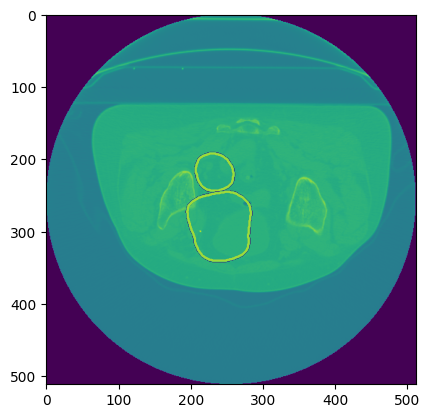

In [ ]:
plt.imshow(np.rot90(ct[100, ...], 2))
plt.contour(prostate[100, ...])
plt.contour(rectum[100, ...])
plt.contour(bladder[100, ...])

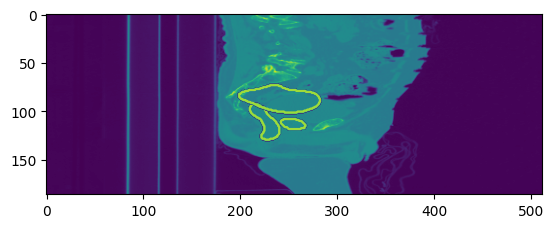

In [ ]:
plt.imshow(ct[..., 250])
plt.contour(prostate[..., 250])
plt.contour(rectum[..., 250])
plt.contour(bladder[..., 250])

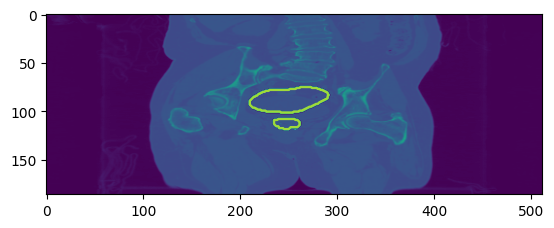

In [ ]:
plt.imshow(ct[:, 250, :])
plt.contour(prostate[:, 250, :])
plt.contour(rectum[:, 250, :])
plt.contour(bladder[:, 250, :])

In [ ]:
from os import listdir
from os.path import isfile, join

prostate_path = "/content/drive/MyDrive/Dissertation-project/Exportation/INPUT/nnUnet/Prostate/seg/"


SyntaxError: ignored

In [ ]:
for i in range(1, 30+1):


['3.nii.gz',
 '1.nii.gz',
 '9.nii.gz',
 '10.nii.gz',
 '14.nii.gz',
 '16.nii.gz',
 '20.nii.gz',
 '18 (1).nii.gz',
 '17 (1).nii.gz',
 '19.nii.gz',
 '12.nii.gz',
 '4.nii.gz',
 '17.nii.gz',
 '13.nii.gz',
 '18.nii.gz',
 '5.nii.gz',
 '7.nii.gz',
 '15.nii.gz',
 '6.nii.gz',
 '8.nii.gz',
 '11.nii.gz',
 'plans.pkl',
 '30.nii.gz',
 '25.nii.gz',
 '24.nii.gz',
 '29.nii.gz',
 '23.nii.gz',
 '22.nii.gz',
 'postprocessing.json',
 '21.nii.gz']